## **Bài thực hành bài 12**: Ứng dụng mô hình sequence2sequence cho bài toán dịch máy (machine translation)

Tổng quan: Ở bài tập này chúng ta sẽ lần lượt thực hành các bước để xây dựng một hệ thống học máy cho bài toán dịch máy dựa vào mạng seq2seq: tải và tiền xử lý dữ liệu song ngữ, tạo dữ liệu huấn luyện, xây dựng mô hình seq2seq với attention, hiển thị dữ liệu attention và dịch câu mới trên dữ liệu thực tế. Bài tập yêu cầu các kiến thức về lập trình Python với các thư viện: keras, numpy.

**1. Tải và tiền xử lý dữ liệu**

Nội dung chính: 
1.   Tải dữ liệu song ngữ
2.   Xóa các kí tự đặc biệt trong câu
3.   Tách từ (word tokenizer)
4.   Tạo từ điển
5.   Thêm các token đặc biệt vào câu như : start, end, pad





In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
%cd /content/drive/MyDrive
!mkdir bai13 
%cd /content/drive/MyDrive/bai13

- Import các thư viện cần thiết

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

- Dowload dataset

Trong bài thực hành này chúng ra sẽ sử dụng bộ song ngữ Vietnamese - English gồm 133k cặp câu song ngữ

In [ ]:
OUT_DIR = "data_iwslt15"
!mkdir $OUT_DIR
SITE_PREFIX="https://nlp.stanford.edu/projects/nmt/data"
# Download iwslt15 small dataset from standford website.
print ("Download training dataset train.en and train.vi.")
!curl -o "$OUT_DIR/train.en" "$SITE_PREFIX/iwslt15.en-vi/train.en"
!curl -o "$OUT_DIR/train.vi" "$SITE_PREFIX/iwslt15.en-vi/train.vi"

print ("Download dev dataset tst2012.en and tst2012.vi.")
!curl -o "$OUT_DIR/tst2012.en" "$SITE_PREFIX/iwslt15.en-vi/tst2012.en"
!curl -o "$OUT_DIR/tst2012.vi" "$SITE_PREFIX/iwslt15.en-vi/tst2012.vi"

print ("Download test dataset tst2013.en and tst2013.vi.")
!curl -o "$OUT_DIR/tst2013.en" "$SITE_PREFIX/iwslt15.en-vi/tst2013.en"
!curl -o "$OUT_DIR/tst2013.vi" "$SITE_PREFIX/iwslt15.en-vi/tst2013.vi"

Download training dataset train.en and train.vi.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.9M  100 12.9M    0     0  5411k      0  0:00:02  0:00:02 --:--:-- 5411k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 17.2M  100 17.2M    0     0   620k      0  0:00:28  0:00:28 --:--:--  787k
Download dev dataset tst2012.en and tst2012.vi.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  136k  100  136k    0     0   187k      0 --:--:-- --:--:-- --:--:--  186k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  183k  100  183k    0     0   

- Viết hàm tiền xử lý dữ liệu. Hàm này xử lý dữ liệu đầu vào như xóa bỏ các kí tự đặc biệt, lowercase, ... Ngoài ra ta cũng thêm token bắt đầu và kết thúc câu.

In [ ]:
def preprocess_sentence(sentence):
  sentence = "<start> "+sentence+" <end>"
  return sentence

- Load data và xem thử data

In [ ]:
def load_data(source_file, target_file, number_of_examples):
  # source_data = [preprocess_sentence(source_sentence) 
  #                 for source_sentence in open(source_file, "r").readlines()[:number_of_examples]]
  # target_data = [preprocess_sentence(target_sentence) 
  #                 for target_sentence in open(target_file, "r").readlines()[:number_of_examples]]
  max_len = 50
  source_sents = open(source_file, "r").readlines()
  target_sents = open(target_file, "r").readlines()
  assert len(source_sents) == len(target_sents)

  source_data, target_data = [], []
  for source_sentence, target_sentence in zip(source_sents[:number_of_examples],
                                              target_sents[:number_of_examples]):
    if len(source_sentence.strip().split()) > max_len or len(target_sentence.strip().split()) > max_len:
      continue
    source_data.append(preprocess_sentence(source_sentence))
    target_data.append(preprocess_sentence(target_sentence))
  
  return source_data, target_data

train_src, train_trg = load_data(OUT_DIR+"/train.en", OUT_DIR+"/train.vi", 1000)
print(len(train_src), len(train_trg))
print(train_src[10])
print(train_trg[10])


929 929
<start> And every one of those scientists is in a research group , and every research group studies a wide variety of topics .
 <end>
<start> Mỗi một khoa học gia đều thuộc một nhóm nghiên cứu , và mỗi nhóm đều nghiên cứu rất nhiều đề tài đa dạng .
 <end>


## Câu hỏi 1:  Viết hàm tách từ (tokenizer).
Nhiều ngôn ngữ có thể phân tách các từ bằng dấu cách (space) như tiếng Anh, tiếng Việt, ... Nhưng 1 số ngôn ngữ không có dấu phân tách giữa các từ như tiếng Nhật, tiếng Trung Quốc. Vì vậy, ta cần có tách từ để phân tách các từ trong câu.

In [ ]:
#Viết hàm tách từ với việc xử lý chuyển chữ in hoa thành chữ thường, với những từ không xuất hiện trong vocab sẽ được thay bằng UNK
# hàm tokenizer tách các câu thành từ, trả về tập từ của các câu và bộ tokenizer
def tokenizer(sentences):
  # YOUR CODE HERE
  return sent_tensors, tokenizer

def create_data(source_path, target_path, number_of_examples):
  # creating cleaned input, output pairs
  source_data, target_data = load_data(source_path, target_path, number_of_examples)
  source_tensors, source_tokenizer = tokenizer(source_data)
  target_tensors, target_tokenizer = tokenizer(target_data)

  return source_tensors, target_tensors, source_tokenizer, target_tokenizer

- Giới hạn số dữ liệu huấn luyện. Để kiểm tra xem chương trình chạy có đúng hay không, ban đầu ta có thể chạy thử với lượng nhỏ dữ liệu

In [ ]:
number_of_examples = 30000
train_src_tensors, train_tgt_tensors, train_src_tokenizer, train_tgt_tokenizer = create_data(OUT_DIR+"/train.en", OUT_DIR+"/train.vi", number_of_examples)
valid_src_tensors, valid_tgt_tensors, _, _ = create_data(OUT_DIR+"/tst2012.en", OUT_DIR+"/tst2012.vi", -1)
test_src_tensors, test_tgt_tensors, _, _ = create_data(OUT_DIR+"/tst2013.en", OUT_DIR+"/tst2013.vi", -1)

max_length_source, max_length_target = train_src_tensors.shape[1], train_tgt_tensors.shape[1]

print(len(train_src_tensors))
# print(train_src_tensors[0])

# View source dictionary
print(len(train_src_tokenizer.word_index))
for t in train_src_tensors[0][:5]:
  print(t, train_src_tokenizer.index_word[t])


45952
26370
1 <start>
7615 rachel
14913 pike
56 :
5 the


### Câu hỏi 2: Tạo dữ liệu huấn luyện**

Nội dung chính: Tạo dữ liệu huấn luyện theo batch

In [ ]:
BUFFER_SIZE = len(train_src_tensors)
BATCH_SIZE = 32
steps_per_epoch = len(train_src_tensors)//BATCH_SIZE

vocab_src_size = len(train_src_tokenizer.word_index)+1
vocab_tgt_size = len(train_tgt_tokenizer.word_index)+1

# YOUR CODE HERE
def dataset():
  train = None
  train = None
  return train
# YOUR CODE HERE

example_input_batch, example_target_batch = next(iter(dataset()))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 52]), TensorShape([64, 52]))

### Câu hỏi 3. Viết mô hình seq2seq với attention**
Nội dung chính : Viết Encoder, LuongAttention, Decoder

### Câu hỏi 3.1 Viết encoder

In [ ]:
# Viết hàm Encoder sử dụng mạng RNN
class Encoder(tf.keras.Model):
  def __init__(self, inp_vocab_size, embedding_size, lstm_size, input_length):
    super(Encoder, self).__init__()
    # YOUR CODE HERE
    self.batch_sz = None
    self.hidden_state_size = None
    self.embedding = None
    self.simpleRNN = None


    # YOUR CODE HERE

  def call(self, x, hidden):
    # YOUR CODE HERE
    x = None
    output, state = None
    # YOUR CODE HERE
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.hidden_state_size))

- Tạo Encoder và test thử  Encoder đó với 1 batch dữ liệu và in ra shape của encoder output

In [ ]:
embedding_dim = 512
hidden_state_size = 512


encoder = Encoder(vocab_src_size, embedding_dim, hidden_state_size, BATCH_SIZE)


# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))
#

In [ ]:
class LuongAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(LuongAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    values_transposed = tf.transpose(values, perm=[0, 2, 1])
    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = tf.transpose(tf.matmul(query_with_time_axis, values_transposed) , perm=[0, 2, 1])

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = LuongAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

### Câu hỏi 3.2 Viết decoder

In [ ]:
#Viết hàm Decoder với mạng RNN
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, hidden_state_size, batch_sz):
    super(Decoder, self).__init__()
    # YOUR CODE HERE
    self.batch_sz = None
    self.hidden_state_size = None
    self.embedding = None
    self.simpleRNN = None
    self.fc = None
    # YOUR CODE HERE
    
    # used for attention
    self.attention = LuongAttention(self.hidden_state_size)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = None

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = None

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = None

    # passing the concatenated vector to the RNN
    output, state = None

    # output shape == (batch_size * 1, hidden_size)
    output = None

    # output shape == (batch_size, vocab)
    x = None

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tgt_size, embedding_dim, hidden_state_size, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 12469)


### Câu hỏi 4: Định nghĩa hàm tối ưu (optimizer) và hàm lỗi (loss function)

Nội dung chính: Sử dụng hàm tối ưu SGD và hàm lỗi CrossEntropy

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  # YOUR CODE HERE
  mask = None)
  loss_ = None

  mask =None
  loss_ *= None
  # YOUR CODE HERE

  return tf.reduce_mean(loss_)
optimizer = None

### Câu hỏi 5. Huấn luyện mô hình (Training)

Nội dung chính: Sử dụng dữ liệu, mô hình seq2seq + attention đã build ở trên để huấn luyện mô hình.

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0
  # YOUR CODE HERE
  with tf.GradientTape() as tape:
    enc_output, enc_hidden,enc_state = None

    dec_hidden = None

    dec_input = None
    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions = None

      loss += None

      dec_input = None
  # YOUR CODE HERE


  batch_loss = (loss / int(targ.shape[1]))

  variables = model.layers[0].trainable_variables + model.layers[1].trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

checkpoint_dir = './model_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

EPOCHS = 1

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = model.layers[0].initialize_hidden_state(64)
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset().take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
      
  checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

### Câu hỏi 6. Dịch (Translate)**

Nội dung chính: Sử dụng mô hình đã được huấn luyện để  dịch dữ liệu mới

In [ ]:
def predict(input_sentence):
  attention_plot = np.zeros((output_len, input_len))

  input_sentence = preprocess_sentence(input_sentence)

  inputs = [inp_lang.word_index[i] for i in input_sentence.split()]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=input_len,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  # YOUR CODE HERE
  hidden = None

  enc_out, enc_hidden = None

  dec_hidden = None
   
  dec_input = None

  for t in range(output_len):
    predictions,state_h,state_c,attention_weights,context_vector = None

    # storing the attention weights to plot later on
    attention_weights = None
    attention_plot[t] = None
    predicted_id = None
    result += None
  # YOUR CODE HERE

    if targ_lang.index_word[predicted_id] == '<end>':
     return result, input_sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, input_sentence, attention_plot


Input: <start> How are you ? <end>
Predicted translation: chúng ta có thể làm thế giới .
 <end> 


In [ ]:
source_sentence = "Hello how are you ?"
result, sent, attention_plot = predict(source_sentence)
print('Input: %s' % (sent))
print('Predicted translation: {}'.format(result))

**7. Hiển thị attention (Plot attention)**

Nội dung chính : Hiển thị attention để hiểu rõ hơn vai trò của attention trong mô hình seq2seq


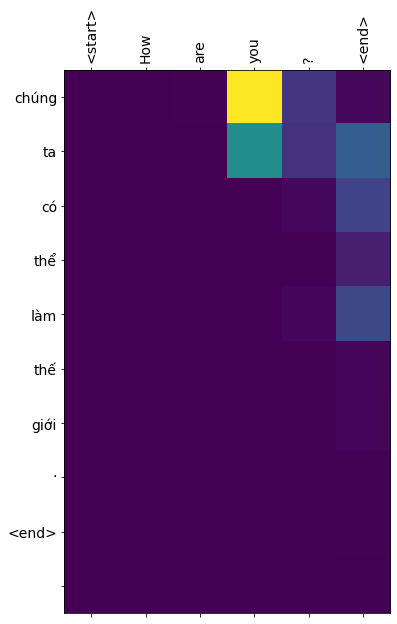

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

attention_plot = attention_plot[:len(result.split(' ')), :len(source_sentence.split(' '))]
plot_attention(attention_plot, source_sentence.split(' '), result.split(' '))

**8. Tính điểm BLEU**

BLEU là 1 độ đo rất phổ biến để đánh giá chất lượng của 1 hệ thống dịch máy. Bạn có thể download script tính multi-bleu tại github của mosesdecoder : https://github.com/moses-smt/mosesdecoder/blob/master/scripts/generic/multi-bleu.perl

Trong bài này, chúng tôi sẽ sử dụng hàm tính bleu có sẵn trong python.

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'a', 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate)
print(score)

1.0
